#### Import Statements

In [1]:
# Data structures
import pandas as pds
import numpy as np;

# Plotting
from matplotlib import pyplot as plt

#### Background Information

Our data comes from [this url](https://github.com/astronexus/HYG-Database):

In [2]:
url = 'https://raw.githubusercontent.com/astronexus/HYG-Database/master/hygdata_v3.csv'

This is a more extensive star catalogue that maps Hubble features such as radial velocity and its components to some arbitrary identifier.  This **does not** match up with the SDSS data.  This is because, there, their ID's reflect how the data was measured.  Here, their ID's are arbitrary, but the ID of the Sun is 0.  

We can read the data by the following:

In [3]:
star_df = pds.read_csv(url)

In [4]:
# This gives us the top 5 elements.  There are way more than 5 in the set.
star_df.head()

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,1,0,NaN,1.000000,NaN,NaN,NaN
1,1,1.0,224700.0,NaN,NaN,NaN,NaN,0.000060,1.089009,219.7802,...,NaN,NaN,Psc,1,1,NaN,9.638290,NaN,NaN,NaN
2,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,...,NaN,NaN,Cet,1,2,NaN,0.392283,NaN,NaN,NaN
3,3,3.0,224699.0,NaN,NaN,NaN,NaN,0.000335,38.859279,442.4779,...,NaN,NaN,And,1,3,NaN,386.901132,NaN,NaN,NaN
4,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,...,NaN,NaN,Phe,1,4,NaN,9.366989,NaN,NaN,NaN


Note that there are a bunch of columns that we don't really care about for these purposes, so we can reduce that by the following.  These are mostly different identifiers or values we can calculate ourselves, much faster.  By reducing the size of the dataframe, computation speed increases:

In [5]:
star_df.keys()

Index(['id', 'hip', 'hd', 'hr', 'gl', 'bf', 'proper', 'ra', 'dec', 'dist',
       'pmra', 'pmdec', 'rv', 'mag', 'absmag', 'spect', 'ci', 'x', 'y', 'z',
       'vx', 'vy', 'vz', 'rarad', 'decrad', 'pmrarad', 'pmdecrad', 'bayer',
       'flam', 'con', 'comp', 'comp_primary', 'base', 'lum', 'var', 'var_min',
       'var_max'],
      dtype='object')

In [18]:
reduced_star_df = star_df.drop(['hip', 'hd', 'hr', 'gl', 'bf', 'proper',
                                'rarad', 'decrad', 'pmrarad', 'pmdecrad',
                                'bayer', 'flam', 'con', 'comp', 'comp_primary',
                                'base', 'var', 'var_min', 'var_max'], 
                                axis = 1)

In [19]:
reduced_star_df['ra'].max()

23.998594

Now, like the SDSS data, it is necessary to limit the data to a specific path of the sky.  Before that, some considerations:

* Right Ascension ($\alpha$) is on the range $[0^\circ, 360^\circ]$.
* Declination ($\delta$) is on the range $[-90^\circ, 90^\circ]$.

More can be [found here](https://www.britannica.com/science/declination).  So, we can define a function `angular_patch` which does exactly this:

In [20]:
def angular_patch(ra, dec, sky, cs = None):
    
    # ra -> a tuple containing lower [0] and upper [1] bounds.
    # dec -> a tuple containing lower [0] and upper [1] bounds.
    # sky -> the dataframe of the sky.
    # cs -> optional parameter of color indices.
    
    ra_lims = (sky['ra'] > ra[0]) & (sky['ra'] < ra[1])
    dec_lims = (sky['dec'] > dec[0]) & (sky['dec'] < dec[1])
    
    # NumPy / Pandas vectorized indexing lets us do this.
    if cs != None:
        return sky[ra_lims & dec_lims], cs[ra_lims & dec_lims]
    else: return sky[ra_lims & dec_lims]

A fair example:

In [35]:
ra = (0, 10)
dec = (0, 1)

patch_0 = angular_patch(ra, dec, reduced_star_df)

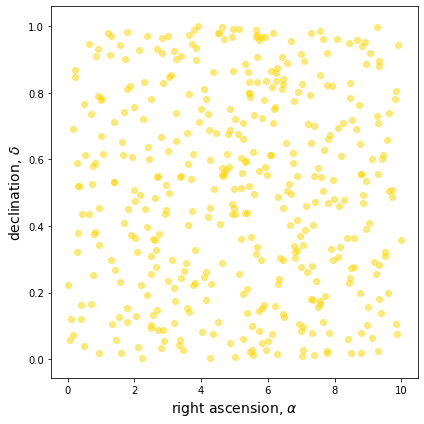

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

ax.scatter(patch_0['ra'], patch_0['dec'], color = 'gold', alpha = 0.5)

ax.set_ylabel(r'declination, $\delta$', fontsize = 14)
ax.set_xlabel(r'right ascension, $\alpha$', fontsize = 14)

fig.tight_layout()

The aspect isn't quite right, so we can fix it by the following:

In [37]:
aspect = lambda ra, dec: 1/np.cos((dec[0] + dec[1])/2*np.pi/180)

A `lambda` object is just a function without a return statement.

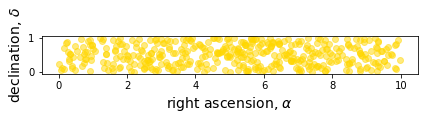

In [38]:
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111, aspect = aspect(ra, dec))

ax.scatter(patch_0['ra'], patch_0['dec'], color = 'gold', alpha = 0.5)

ax.set_ylabel(r'declination, $\delta$', fontsize = 14)
ax.set_xlabel(r'right ascension, $\alpha$', fontsize = 14)

fig.tight_layout()

This more accurately represents the bunching that's happening.  Another problem emerges in that the sizes here don't necessarily reflect the size of the actual object.  That is to say, not all stars are the same size.  We can make some assumptions, namely that luminosity $L$ is proportional to surface area $A$.  This comes from

\begin{equation}
L = \sigma A T^4
\end{equation}

where $\sigma$ is the Boltzmann constant and $T$ is temperature.  More can be [found here](https://en.wikipedia.org/wiki/Luminosity#Luminosity_formulae).  Therefore, the more luminuous the object is the larger it should be.  Note that this assumes they all radiate at the same temperature, which is not true!  So, we can fit our approximation in as such:

In [39]:
def get_object_size(sky, multiple = 1000):
    
    lums = np.array(sky['lum'])
    normalized_lums = (lums - lums.min())/(lums.max() - lums.min())
    
    return normalized_lums * multiple

Consider that this puts object size $s$ on the range $s \in \text{ multiple } * [0, 1]$ because we normalized it such that the lowest value is zero and the largest value is one.  The multiple allows us to control the size of objects.  Replotting:

In [40]:
sizes = get_object_size(patch_0)

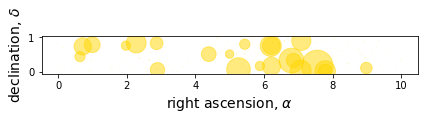

In [41]:
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111, aspect = aspect(ra, dec))

ax.scatter(patch_0['ra'], patch_0['dec'], color = 'gold', alpha = 0.5, s = sizes)

ax.set_ylabel(r'declination, $\delta$', fontsize = 14)
ax.set_xlabel(r'right ascension, $\alpha$', fontsize = 14)

fig.tight_layout()

This does reduce noise, but consider that so many objects are infinitely small due to the resizing.  We can also change alpha so that it reflects the magnitude of the object, but first we need to create a color map:

In [42]:
def get_color_map(sky, cs = None):
    
    if cs == None:
        colors = np.array([np.random.rand(4,) for _ in range(sky.shape[0])])
    else:
        colors = np.zeros((sky.shape[0], 4))
        colors[:, 0:3] = cs
    
    absmag = abs(np.array(sky['absmag']))
    normalized_absmag = (absmag - absmag.min())/(absmag.max() - absmag.min())
    
    colors[:, 3] = normalized_absmag
    return colors

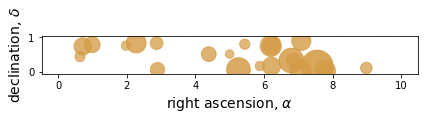

In [43]:
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111, aspect = aspect(ra, dec))

ax.scatter(patch_0['ra'], patch_0['dec'], c = get_color_map(patch_0, cs = [0.83, 0.61, 0.28]), s = sizes)

ax.set_ylabel(r'declination, $\delta$', fontsize = 14)
ax.set_xlabel(r'right ascension, $\alpha$', fontsize = 14)

fig.tight_layout()

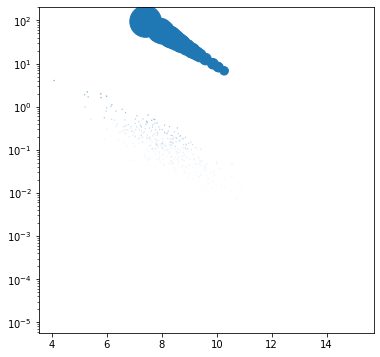

In [44]:
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111)

ax.scatter(patch_0['mag'], patch_0['lum']/patch_0['dist'], s = sizes)

ax.set_yscale('log')

In [45]:
filtered_patch0['lum']/(4*np.pi*filtered_patch0['dist']**2)

6743     3.197350e-06
8791     1.502416e-05
12473    3.571002e-06
13213    1.078425e-06
45916    6.804405e-07
dtype: float64

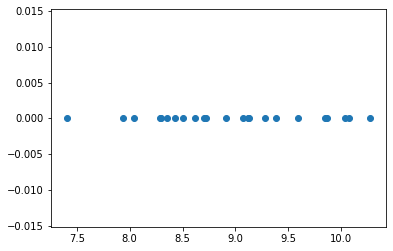

In [48]:
plt.scatter(filtered_patch0['mag'], filtered_patch0['lum']/(4*np.pi*filtered_patch0['dist']**2))

Text(0.5, 0, 'magnitude')

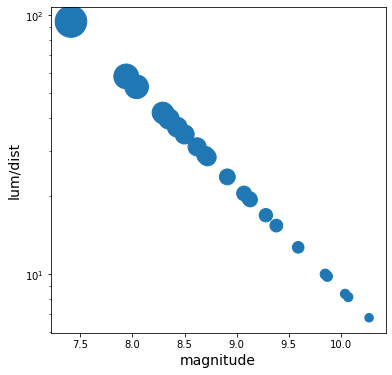

In [47]:
size_filter = sizes >= sizes.mean()
filtered_patch0 = patch_0[size_filter]
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111, aspect = aspect(ra, dec))

ax.scatter(filtered_patch0['mag'], (filtered_patch0['lum']/filtered_patch0['dist']), s = sizes[size_filter])

ax.set_yscale('log')
ax.set_ylabel('lum/dist', fontsize = 14)
ax.set_xlabel('magnitude', fontsize = 14)

Define:
 * L = luminosity
 * d = distance
 * M = magntitude


 
 Therefore,
 \begin{equation}
 \log\left(\dfrac{L}{d}\right) = Ms + b
 \end{equation}
 
 We can use this with NumPy's polyfit.

In [71]:
s, b = np.polyfit(filtered_patch0['mag'], np.log((filtered_patch0['lum']/filtered_patch0['dist'])), 1)

In [72]:
print(s, b)

-0.9210340371976181 11.374770359390586


Here, $s$ is the slope of the line and $b$ is the intercept.  We can then rearrange this to solve for $L$ such that

\begin{equation}
e^{\log(\dfrac{L}{d})} = e^{Ms + b} = e^{Ms} e^{b} = Be^{Ms}
\end{equation}

where $B = e^{b}$ such that

\begin{equation}
\dfrac{L}{d} = Be^{Ms}
\end{equation}

Note that $d$ is in parsecs, $L$ is a multiple of solar luminosity by the form $L = n S$ so it can be converted to Watts.  We can do unit analysis such that

\begin{equation}
\dfrac{L}{d} = \dfrac{E}{td} = \dfrac{mad}{td} = \dfrac{F}{t}
\end{equation}

where $F$ is force.

In [77]:
exact = filtered_patch0['lum']/filtered_patch0['dist']

In [78]:
approx = np.exp(b)*np.exp(s*filtered_patch0['mag'])

In [79]:
abs(np.array(exact) - np.array(approx)).sum()

2.4077628779650695e-11

https://en.wikipedia.org/wiki/Luminosity_distance

## TO-DO:

In [95]:
def distance_limits(dist, z, df, cs):
    dist_lim = dist > np.sqrt(df['x']**2 + df['y']**2)
    z_lim = (z[1] > df['z']) & (z[0] < df['z'])
    return df[dist_lim & z_lim], cs[dist_lim & z_lim]

In [ ]:
def lum_limits(lum, df, cs):
    lum_lim = lum > df['lum']

In [115]:
def plot_range(dist, z, df, cs):
    patch, ncs = distance_limits(dist, z, df, cs)
 
    alphas = np.array(abs(patch['absmag'])/abs(patch['absmag']).sum())
    alph = (alphas - alphas.min())/(alphas.max() - alphas.min())
    
    lums = np.array(patch['lum'])
    lum = (lums - lums.min())/(lums.max() - lums.min())
    lum *= 1000
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize = (9,9))
    ax = fig.add_subplot(111)

    for i, (idx, p) in enumerate(patch.iterrows()):

        if p['id'] == 0:
            ax.scatter(p['x'], p['y'], alpha = 1, s = lum[i], marker = 's', c = 'k')
        else: ax.scatter(p['x'], p['y'], alpha = 0.5, s = lum[i], color = ncs[i])

In [116]:
cs = np.array([np.random.rand(3,) for _ in range(new_df.shape[0])])

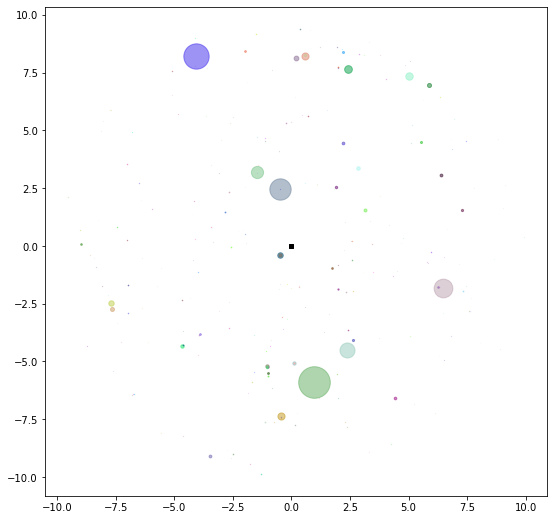

In [126]:
plot_range(10, (-5, 5), new_df, cs);

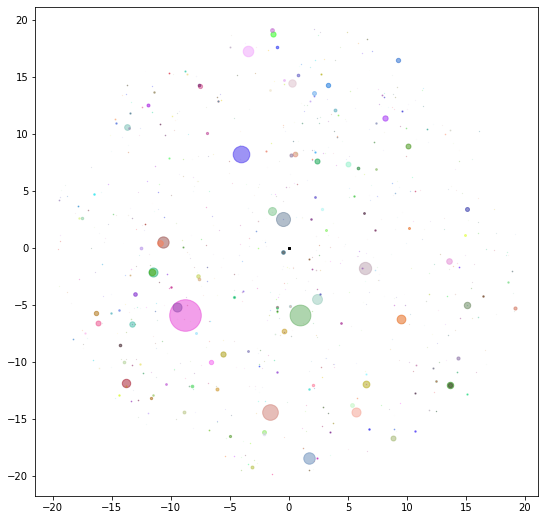

In [125]:
plot_range(20, (-5, 5), new_df, cs);

In [127]:
new_df.sort_values(by = ['dist'])

,id,ra,dec,dist,pmra,pmdec,rv,mag,absmag,spect,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,0.000000,0.000000,0.0000,0.00,0.00,0.0,-26.70,4.850,G2V,...,NaN,NaN,NaN,1,0,NaN,1.000000e+00,NaN,NaN,NaN
70666,70666,14.495985,-62.679485,1.2959,-3775.64,768.16,-16.0,11.01,15.447,M5Ve,...,NaN,NaN,Cen,1,70666,NaN,5.770321e-05,V645,11.079,10.939
71453,71453,14.660346,-60.838300,1.3248,-3678.19,481.84,-26.2,1.35,5.739,K1V,...,Alp-2,NaN,Cen,2,71456,Gl 559,4.409608e-01,NaN,NaN,NaN
71456,71456,14.660765,-60.833976,1.3248,-3678.19,481.84,-26.2,-0.01,4.379,G2V,...,Alp-1,NaN,Cen,1,71456,Gl 559,1.543121e+00,NaN,0.113,-0.087
87665,87665,17.963472,4.693388,1.8238,-797.84,9999.99,-111.0,9.54,13.235,sdM4,...,NaN,NaN,Oph,1,87665,NaN,4.425884e-04,V2500,9.590,9.490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112790,112790,22.912914,-6.964064,100000.0000,2.34,-8.72,-42.0,10.75,-9.250,R...,...,NaN,NaN,Aqr,1,112790,NaN,4.365158e+05,NaN,10.814,10.674
99570,99570,20.266915,2.111512,100000.0000,0.31,-2.84,0.0,12.28,-7.720,M3,...,NaN,NaN,Aql,1,99570,NaN,1.066596e+05,V1480,12.636,11.996
112792,112792,22.913395,50.963615,100000.0000,-1.75,-5.29,0.0,8.71,-11.290,Ap,...,NaN,NaN,Lac,1,112792,NaN,2.857591e+06,NaN,NaN,NaN
32716,32716,6.838202,4.546569,100000.0000,-0.30,-2.02,0.0,9.06,-10.940,F0,...,NaN,NaN,Mon,1,32716,NaN,2.070141e+06,NaN,NaN,NaN


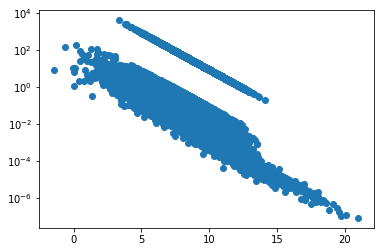

In [162]:
plt.scatter(new_df['mag'], new_df['lum']/new_df['dist'])

plt.yscale('log')

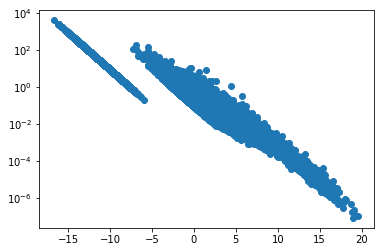

In [163]:
plt.scatter(new_df['absmag'], new_df['lum']/new_df['dist'])

plt.yscale('log')